<a href="https://colab.research.google.com/github/Ciela-Institute/Astromatic/blob/main/Astromatic2023/p6_galactic_center_excess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

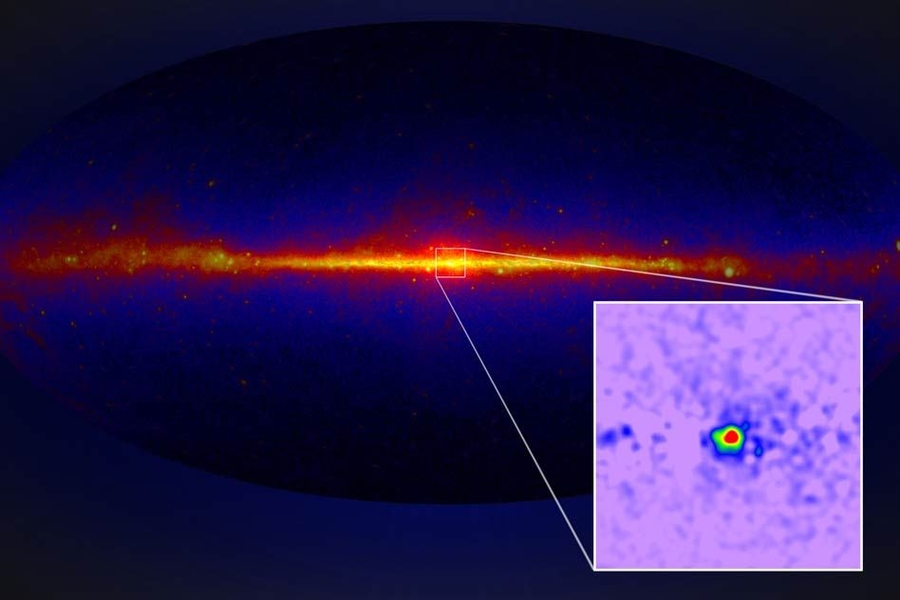

[Source: MIT News](https://news.mit.edu/2019/center-milky-way-dark-matter-gce-1211)

## Problem 6: have we discovered dark matter in the center of the Milky Way?

### Problem description

We know dark matter (DM) makes up 85% of the universe's mass, but we still have not identified its fundamental components. One very well-motivated possibility is that it is a *weakly interacting massive particle (WIMP)* -- a particle with a mass between 1-1000 times that of a proton. If that's the case, DM in our galaxy could annihilate with itself and produce gamma rays. The gamma-ray signal from DM annihilation should be strongest in the center of the galaxy, where the DM density is the largest.

That's why there was a huge amount of excitement when the Fermi Large Area Telescope (LAT) observed an unexpected excess of gamma-rays coming from the Galactic Center. While this excess can be explained by DM, debate has raged for the past 13 years over whether astrophysics can explain it instead. The main astrophysical explanation is *millisecond pulsars (MSPs)*. These rapidly-rotating remnants of massive stars have extremely strong magnetic fields, which accelerate particles to high energies, causing them to emit gamma rays. The brightest ones appear as *point sources* -- small spots in the gamma-ray sky. Gas emission and other mechanisms also produce gamma rays.

The goal of this problem is to infer the dark matter and astrophysical contributions from 2D images of the gamma-ray sky around the Galactic Center.

### What is the main issue?

It is extremely difficult to determine how well the DM's parameters can be measured while properly averaging over possible point source configurations. Critically, there may be thousands of point sources in the Galactic Center. Typical statistical tools like Markov-chain Monte Carlo (MCMC) require modeling *every single point source*. This is hard because first of all we don't know how many point sources are present! Second, many of them are very dim. This makes them hard to measure individually, but they still contribute strongly to the gamma-ray emission when considered all together. Third, there is a labeling problem. We can switch which point sources we label as "1" and "2" without changing the observation. This means the posterior has n! modes -- one for each point source.

As a result, different analyses make different assumptions to enable application of tools like MCMC. This makes it challenging to compare analyses and figure out whether we're really seeing dark matter.

### What is the potential solution to this problem?

New ML tools make it possible to make measurements directly from images, and perform the difficult marginalization over thousands of parameters.

### What data will be used?

This notebook contains a hand-crafted simulator to generate images of the Galactic Center. Running the simulator's `sample()` method generates a `dict` containing a random sample from the model.

The simulator models the following emission components with entries in the `sample`:
- Point sources distributed symmetrically around the Galactic Center. The number of sources generated is `sample["n_ps_gc"]`. The positions and fluxes of the point sources are randomly sampled each time the simulator is run. `samples["flux_ps_gc"]` contains the point source contribution in each pixel.
- Point sources distributed in the galactic disk. The number of sources generated is `sample["n_ps_disk"]`. `samples["flux_ps_disk"]` contains the point source contribution in each pixel.
- Emission tracing the gas distribution, arising from e.g. $\pi^0 \to \gamma\gamma$ decay and bremsstrahlung. This component is modeled as a Gaussian process, with values in `sample["template_pi0"]` and normalization `sample["A_pi0"]`.
- Inverse Compton emission. This comes from high-energy cosmic rays Compton upscattering low-energy cosmic microwave background (CMB) and starlight photons to higher energies. It is smoother that that previous emission components. Its normalization is `sample["A_ic"]`.
- Fermi bubbles. These are two huge, faint lobes extending far above and below the galactic plane. This component's normalization is `sample["A_bubbles"]`.
- **Dark matter.** The emission is spherically-symmetric and sharply peaked towards the Galactic Center. Its normalization is `sample["A_dm"]`, and is related to the strength with which DM self-annihilates.
All normalizations `A_x` range between 0 and 1.

To generate an observation, the simulator samples all the afformentioned components to get `sample["mu"]`. It applies a point spread function that slightly blurs the image. Since Fermi LAT observations consist of the number of photons recorded in a given pixel in the detector, it samples the observation from a Poisson distribution with mean equal to this blurred image. **The final observation is `sample["img"]`.**

In the "Inference" section below, you can see a plot of all these components for a sample from the simulator.

### Milestones estimators

- A good first step would be **making a network that can predict the DM normalization parameter `A_dm` from an image**. The number of point sources in the disk and Galactic Center (`n_ps_disk` and `n_ps_gc`) are also important parameters to try to predict. A convolutional neural network might work well.
- **Find which pixels contain point sources** -- ie, try to predict `samples["flux_ps_gc"]` and `samples["flux_ps_disk"]`. This requires mapping an image (the observation) to another image. *U-nets* are a typical method for doing this.
- **Quantify how well key parameters can be measured.** *Marginal neural ratio estimation* is a good tool for this. You can write your own implementation, or try the [swyft](https://github.com/undark-lab/swyft/tree/lightning-dev) package. If you're interested in swyft, talk to Adam Coogan.

Some very challenging things to explore:
- **Compare with other methods** like wavelet transforms or non-Poissonian template fitting.
- **Make the simulator more realistic.** You could increase the resolution of the images, change the priors, or even add different energy bands.

### Useful references

- [Possible Evidence For Dark Matter Annihilation In The Inner Milky Way From The Fermi Gamma Ray Space Telescope](https://arxiv.org/abs/0910.2998) -- the first paper to find the excess
- [Indirect Detection of Dark Matter in the Galaxy](https://arxiv.org/abs/2006.00513) -- particularly section 5 for a recent overview of the Galactic Center excess
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
- [Likelihood-free MCMC with Amortized Approximate Ratio Estimators](https://arxiv.org/abs/1903.04057)

## Imports

In [1]:
from dataclasses import dataclass, field
from functools import lru_cache
from math import pi

import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from torch.utils.data import DataLoader
from tqdm.auto import trange


plt.rcParams["image.cmap"] = "inferno"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## Simulator setup

In [2]:
def get_meshgrid(resolution, nx, ny, device=None):
    """
    Constructs meshgrids.
    """
    dx = resolution
    dy = resolution

    # Coordinates at pixel centers
    x = torch.linspace(-1, 1, int(nx), device=device) * (nx - 1) * dx / 2
    y = torch.linspace(-1, 1, int(ny), device=device) * (ny - 1) * dy / 2

    # Note difference to numpy (!)
    Y, X = torch.meshgrid((y, x), indexing='ij')

    return X, Y


@dataclass
class Simulator:
    extent: float = 15.0
    """Observation size [deg]"""

    n_pix: int = 64
    """Number of pixels"""

    d_gc: float = 8.3
    """Distance to galactic center [kpc]"""

    sigma_pi0: float = 0.25
    """Length scale associated with spatial variations in pi0 emission [deg]."""

    pi0_disk_height: float = 5.0
    """Disk height for pi0 emission"""

    pi0_disk_radius: float = 20.0
    """Disk radius for pi0 emission"""

    disk_height_ic: float = 5.0
    """Disk height for IC emission [deg]."""

    bubble_smoothing_scale: float = 0.6
    """Smoothing scale for Fermi bubble template [deg]."""

    ps_disk_height: float = 0.3
    """Disk scale height for disk-correlated point sources [kpc]."""

    ps_disk_radius: float = 5.0
    """Disk scale radius for disk-correlated point sources [kpc]."""

    dm_dist_concentration: float = 0.5
    """Steepness of DM emission."""

    dm_dist_scale: float = 5.0
    """Spatial scale of DM emission [deg]."""

    containment_radius: float = 0.8 / 3
    """Very approximate 68% containment radius for PSF [deg]."""

    def __post_init__(self):
        # Image grid
        self.resolution = 2 * self.extent / self.n_pix
        self.X, self.Y = get_meshgrid(self.resolution, self.n_pix, self.n_pix)

        # Gaussian kernel for point spread function used to blur the observation
        X_k, Y_k = get_meshgrid(self.resolution, 5, 5)
        self.psf_kernel = torch.exp(-(X_k**2 + Y_k**2) / (2 * self.containment_radius**2))

        # Kernel for Gaussian process used to model pi0 emission
        pts = torch.stack([self.X.flatten(), self.Y.flatten()])
        d2s = ((pts[:, :, None] - pts[:, None, :]) ** 2).sum(0)
        self.kernel_pi0 = (-d2s / (2 * self.sigma_pi0**2)).exp()

    def sample_pi0_template(self):
        """
        Samples pi0 emission
        """
        # Manually rescale to make it look more realistic
        emission = (self.kernel_pi0 @ torch.randn(self.n_pix**2)).reshape(
            self.n_pix, self.n_pix
        )
        emission = 50 * torch.exp(emission / 8)
        return (
            emission
            * torch.exp(-((self.X / self.pi0_disk_radius) ** 2))
            * torch.exp(-((self.Y / self.pi0_disk_height) ** 2))
        )

    def template_ic(self):
        """
        Gets IC emission, which is smooth and fixed
        """
        return 25 * torch.exp(-self.Y.abs() / self.disk_height_ic)

    def template_bubbles(self):
        """
        Gets Fermi bubbles emission, which is smooth and fixed
        """
        Y_norths = 10.5 * (torch.cosh((-self.X - 1) / 10.5) - 1) + 1
        Y_souths = -8.7 * (torch.cosh((-self.X + 1.7) / 8.7) - 1) - 1
        # Apply some hacky smoothing to the edges of the bubbles
        emission = torch.zeros([self.n_pix, self.n_pix])
        emission[self.Y > 0] = torch.sigmoid(
            (self.Y[self.Y > 0] - Y_norths[self.Y > 0]) / self.bubble_smoothing_scale
        )
        emission[self.Y < 0] = torch.sigmoid(
            (Y_souths[self.Y < 0] - self.Y[self.Y < 0]) / self.bubble_smoothing_scale
        )
        return 3 * emission

    def template_dm(self):
        """
        Computes smooth emission from DM annihilation
        """
        dm_dist = dist.Gamma(self.dm_dist_concentration, 1 / self.dm_dist_scale)
        # Distance to galactic center
        rs = torch.sqrt(self.X**2 + self.Y**2)
        return 100 * dm_dist.log_prob(rs).exp()

    def _sample_ps_gc_xy(self, n: int):
        # Use same distribution as for DM emission
        ps_gc_dist = dist.Gamma(self.dm_dist_concentration + 1, 1 / self.dm_dist_scale)
        rs = ps_gc_dist.sample((n,))
        angles = torch.rand(n) * 2 * pi
        xs = rs * torch.cos(angles)
        ys = rs * torch.sin(angles)
        return xs, ys

    def _sample_ps_disk_xy(self, n: int):
        # Convert to degrees
        scale_radius = self.ps_disk_radius / self.d_gc * 180 / pi
        scale_height = self.ps_disk_height / self.d_gc * 180 / pi

        rs = dist.Exponential(1 / scale_radius).sample((n,))
        ys = dist.Exponential(1 / scale_height).sample((n,))

        # Randomly put pulsars above or below the galactic plane
        ys *= 2 * ((torch.rand(n) > 0.5).float() - 0.5)

        # Project radial coordinate
        angles = 2 * pi * torch.rand(n)
        xs = rs * torch.cos(angles)

        return xs, ys

    def _sample_pss_in_image(self, pos_sampler, n: int):
        # Sample positions until n lie inside the image
        xs, ys = pos_sampler(n)
        while True:
            idx_oob = (xs.abs() > self.extent) | (ys.abs() > self.extent)
            n_oob = idx_oob.sum()
            if n_oob == 0:
                break
            else:
                xs[idx_oob], ys[idx_oob] = pos_sampler(n_oob)

        return xs, ys

    def _pixelate_pss(self, xs, ys, fluxes):
        """
        Creates pixelated map by histogramming point source positions and fluxes.
        """
        # Map onto pixel grid
        bins = torch.linspace(-self.extent, self.extent, self.n_pix + 1)
        return torch.histogramdd(
            torch.stack([ys, xs], 1), bins=(bins, bins), weight=fluxes
        ).hist

    def sample(self) -> dict:
        """
        Simulate all the emission components
        """
        trace = {}

        # Template normalizations
        trace["A_ic"] = torch.rand(1)
        trace["A_pi0"] = torch.rand(1)
        trace["A_bubbles"] = torch.rand(1)
        trace["A_dm"] = torch.rand(1)

        # Sample pi0 template
        trace["template_pi0"] = self.sample_pi0_template()

        # Number of point sources
        n_ps_gc = trace["n_ps_gc"] = torch.randint(low=200, high=800, size=(1,))
        n_ps_disk = trace["n_ps_disk"] = torch.randint(low=1000, high=4000, size=(1,))

        # Sample fluxes
        ps_log_flux_mean = 1.0
        ps_log_flux_scale = 1.2
        dist_ps_fluxes = dist.LogNormal(ps_log_flux_mean, ps_log_flux_scale)
        ps_gc_fluxes = dist_ps_fluxes.sample((n_ps_gc,))
        ps_disk_fluxes = dist_ps_fluxes.sample((n_ps_disk,))
        # Sample positions
        xs_ps_gc, ys_ps_gc = self._sample_pss_in_image(self._sample_ps_gc_xy, n_ps_gc)
        xs_ps_disk, ys_ps_disk = self._sample_pss_in_image(self._sample_ps_disk_xy, n_ps_disk)
        # Pixelate
        trace["flux_ps_gc"] = self._pixelate_pss(xs_ps_gc, ys_ps_gc, ps_gc_fluxes)
        trace["flux_ps_disk"] = self._pixelate_pss(xs_ps_disk, ys_ps_disk, ps_disk_fluxes)

        trace["mu"] = (
            trace["A_ic"] * self.template_ic()
            + trace["A_pi0"] * trace["template_pi0"]
            + trace["A_dm"] * self.template_dm()
            + trace["A_bubbles"] * self.template_bubbles()
            + trace["flux_ps_gc"]
            + trace["flux_ps_disk"]
        )

        # Apply PSF and sample noise
        mu_blurred = torch.nn.functional.conv2d(
            trace["mu"][None, None, :, :], self.psf_kernel[None, None, :, :], padding=2,
        )[0, 0, :, :]

        trace["img"] = dist.Poisson(mu_blurred).sample()


        return trace

    def sample_batch(self, n) -> dict:
        samples = [self.sample() for _ in range(n)]
        return torch.utils.data.default_collate(samples)

## Inference

Example observation with each emission component plotted separately. The numbers in the subplots' titles show the mean flux in each pixel.

(The color bars are all the same, which makes some components hard to see. You can change `vmax` to a lower value to make them more visible, or set `vmax=None` to set it automatically.)

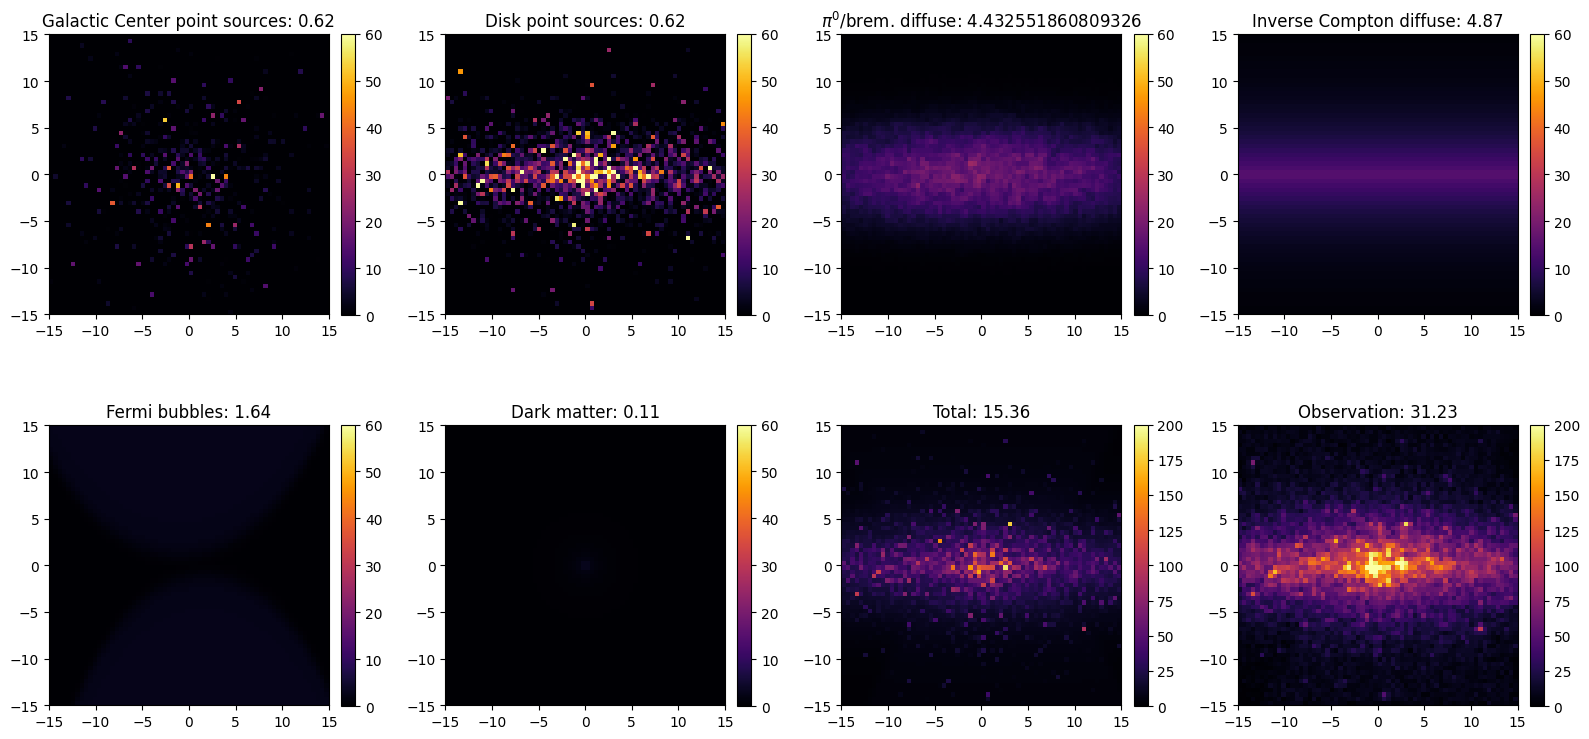

In [5]:
sim = Simulator()
sample = sim.sample()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

ax = axes[0, 0]
im = ax.pcolormesh(sim.X, sim.Y, sample["flux_ps_gc"], vmin=0, vmax=60)
ax.set_title(f"Galactic Center point sources: {sample['flux_ps_gc'].mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 1]
im = ax.pcolormesh(sim.X, sim.Y, sample["flux_ps_disk"], vmin=0, vmax=60)
ax.set_title(f"Disk point sources: {sample['flux_ps_gc'].mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 2]
flux_pi0 = sample["A_pi0"] * sample["template_pi0"]
im = ax.pcolormesh(sim.X, sim.Y, flux_pi0, vmin=0, vmax=60)
ax.set_title(r"$\pi^0$/brem. diffuse: " + f"{flux_pi0.mean().item()}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[0, 3]
flux_ic = sample["A_ic"] * sim.template_ic()
im = ax.pcolormesh(sim.X, sim.Y, flux_ic, vmin=0, vmax=60)
ax.set_title(f"Inverse Compton diffuse: {flux_ic.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 0]
flux_bubbles = sample["A_bubbles"] * sim.template_bubbles()
im = ax.pcolormesh(sim.X, sim.Y, flux_bubbles, vmin=0, vmax=60)
ax.set_title(f"Fermi bubbles: {flux_bubbles.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 1]
flux_dm = sample["A_dm"] * sim.template_dm()
im = ax.pcolormesh(sim.X, sim.Y, flux_dm, vmin=0, vmax=60)
ax.set_title(f"Dark matter: {flux_dm.mean().item():.2f}")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1, 2]
im = ax.pcolormesh(sim.X, sim.Y, sample["mu"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Total: {sample['mu'].mean().item():.2f}")

ax = axes[1, 3]
im = ax.pcolormesh(sim.X, sim.Y, sample["img"], vmin=0, vmax=200)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title(f"Observation: {sample['img'].mean().item():.2f}")

for ax in axes.flatten():
    ax.set_aspect("equal")

fig.tight_layout()

# Your solution

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, simulator, size:int=1000):
        self.size = size # number of simulations in an epoch
        self.simulator = simulator

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        sample = self.simulator.sample(B)
        # sample["img"] is generally what is observed by your network
        # sample["A_dm"] is what you want to infer
        return sample

### Start here

In [ ]:
B = ... # batch size
simulator = Simulator()
dataset = Dataset(simulator)
dataloader = DataLoader(dataset, batch_size=B)